# **CS224W - Colab 5**

In this Colab we will experiment on scaling up GNNs using PyTorch Geometric, DeepSNAP and NetworkX. As we have **canceled** the Colab 5 assignment, this notebook will be a tutorial and you do not need to submit it on Gradescope.

At first, we will use PyTorch Geometric `NeighborSampler` to scale up the training and testing on OGB `arxiv` dataset.

Then, using the DeepSNAP and NetworkX, we will implement a simplified version of `NeighborSampler` and run experiments with different smapling ratios on the Cora graph.

At last, we will partition the Cora graph into clusters by using different partition algorithms and then train the models in the way of vanilla Cluster-GCN.

**Note**: Make sure to **sequentially run all the cells in each section**, so that the intermediate variables / packages will carry over to the next cell

# Device
You might need to use GPU for this Colab.

Please click `Runtime` and then `Change runtime type`. Then set the `hardware accelerator` to **GPU**.

# Installation

In [1]:
!nvidia-smi

Mon Jul 25 11:55:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# !pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
# !pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
# !pip install -q torch-geometric
# !pip install -q ogb
# !pip install -q git+https://github.com/snap-stanford/deepsnap.git

In [2]:
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.12.0+cu113.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.12.0+cu113.html
!pip install -q torch-geometric

     |████████████████████████████████| 7.9 MB 37.3 MB/s 
     |████████████████████████████████| 3.5 MB 36.8 MB/s 
     |████████████████████████████████| 407 kB 21.0 MB/s 


In [3]:
# Stanford DeepSNAP 설치

!pip install -q git+https://github.com/snap-stanford/deepsnap.git
!pip install -U -q PyDrive

In [4]:
!pip install -q ogb

     |████████████████████████████████| 78 kB 7.2 MB/s 


In [5]:
import torch_geometric
torch_geometric.__version__

'2.0.4'

# 1 PyTorch Geometric Neighbor Sampling

Neighbor Sampling, originally proposed in **GraphSAGE** ([Hamilton et al. (2017)](https://arxiv.org/abs/1706.02216)), is a representative method to scale up GNNs. As what we have learned in lecture, only a K-hop neighborhood nodes will be loaded into GPU for each time training. To further reduce the cost, we can sample a subset of neighborhood nodes for GNNs to aggregate.

- https://kangbk0120.github.io/articles/2020-03/graphsage
- SAGE는 SAmple과 aggreGatE가 결합된 단어입니다. 말 그대로 Neighbor를 Sampling하고 Aggregating한다고 생각할 수 있습니다.
- 기본적인 아이디어는 필요한 모든 노드들을 미리 저장해두는 것입니다. 필요한 노드들만을 모아 미리 가지고 있는 것이죠.
- 논문에서는 일반적으로 K = 2를 사용했다고 합니다.
- 결국 이웃하는 노드들은 서로 비슷한 값을 가지게 만들고, 그렇지 않은 노드들은 다른 값을 가지도록 하는 것이 목표가 됩니다.
- Aggregator 함수의 구조 : 이웃하는 노드들을 입력으로 받는 Aggregator는 이러한 순서에 영향을 받지 않는 함수여야 합니다.  
1) Mean을 사용하는 경우에는 Concat 연산을 따로 적용하지 않는다는 점에 주의  
2) LSTM을 제안합니다. Mean과는 달리 파라미터를 사용하니 더 높은 표현력을 가지겠지만, 순서가 존재한다는 점이 차이입니다. 따라서 임의의 순서로 섞은 이웃 노드들을 입력으로 주게 됩니다.  
3) Pooling Aggregator가 있습니다. 순서와 상관없으며, 학습이 가능하다는 장점이 있습니다. 이웃의 feature들이 각각 fully-connected layer에 입력으로 주어지게 됩니다.

### 본 논문에서 GraphSAGE의 성능은 총 3가지의 벤치마크 task에서 평가되었다.

(1) Web of Science citation 데이터셋을 활용하여 학술 논문을 여러 다른 분류하는 것

(2) Reddit에 있는 게시물들이 속한 커뮤니티를 구분하는 것

(3) 다양한 생물학적 Protein-protein interaction 그래프 속에서 protein 함수를 구별하는 것

## Setup

In [7]:
import copy
import torch

import torch.nn.functional as F

import torch_geometric.transforms as T

from torch_geometric.nn import SAGEConv

# Neighbor Sampling에 활용됨. 주변 이웃들을 샘플링한다.
from torch_geometric.data import NeighborSampler

from ogb.nodeproppred import PygNodePropPredDataset, Evaluator

## Neighbor Sampler

PyTorch Geometric has implemented the Neighbor Sampling method as the [NeighborSampler](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.NeighborSampler) in `torch_geometric.data`. Following is an example that uses the Neighbor Sampling method on training the OGB `arxiv` dataset.

If you are interested in memory-efficient aggregations, please refer to PyG's [Memory-Efficient Aggregations](https://pytorch-geometric.readthedocs.io/en/latest/notes/sparse_tensor.html).

### PyTorch Geometric에서의 Neighbor Sampling
- PyTorch Geometric에서 torch_geometric.data의 NeighborSampler를 활용하면 된다.


In [9]:
# (1) Web of Science citation 데이터셋을 활용하여 학술 논문을 여러 다른 분류하는 것
# ogbn-arxiv
# Each node : is an arXiv paper 
# Each directed edge : indicates that one paper cites another one.
# Each paper : comes with a 128-dimensional feature vector obtained by averaging the embeddings of words in its title and abstract. 

# 논문이 어떤 분야에 속해 있는지에 대하여, Node를 분류하는 것이 바로 이 데이터의 목표다. (40 Subject Areas)
# The task is to predict the 40 subject areas of arXiv CS papers, e.g., cs.AI, cs.LG, and cs.OS, which are manually determined (i.e., labeled) by the paper’s authors and arXiv moderators. 

dataset_name = 'ogbn-arxiv'

# 데이터셋 : Sparse한 Tensor로 변환시켜준다.
dataset = PygNodePropPredDataset(name = dataset_name,
                                 transform = T.ToSparseTensor())

# 데이터 부르고.
data = dataset[0]

# 데이터의 인접 행렬 Adjacency Matrix를 구한다.
# symmetric : 대칭적인
data.adj_t = data.adj_t.to_symmetric()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

Downloaded 0.08 GB: 100%|██████████| 81/81 [00:03<00:00, 23.29it/s]


Extracting dataset/arxiv.zip


Processing...


Loading necessary files...
This might take a while.
Processing graphs...


100%|██████████| 1/1 [00:00<00:00, 9754.20it/s]


Converting graphs into PyG objects...


100%|██████████| 1/1 [00:00<00:00, 3184.74it/s]

Saving...



Done!


cuda


In [10]:
print(device)

cuda


In [22]:
print(data)

# x는 하나당 128차원 : Node Attribute : 그 논문의 특성을 나타낸다.
# node_year는 하나당 1개 : 그 논문이 출판된 연도를 나타낸다.
# y는 하나당 1개 : 그 논문의 라벨을 나타낸다. (여기서는 라벨이 숫자로 나타나고 있음.)
# adj_t는 인접행렬 : 인접한 행렬을 나타낸다.

Data(num_nodes=169343, x=[169343, 128], node_year=[169343, 1], y=[169343, 1], adj_t=[169343, 169343, nnz=2315598])


In [23]:
print(data.adj_t)

SparseTensor(row=tensor([     0,      0,      0,  ..., 169341, 169342, 169342]),
             col=tensor([   411,    640,   1162,  ..., 163274,  27824, 158981]),
             size=(169343, 169343), nnz=2315598, density=0.01%)


In [24]:
print(data.num_nodes)

169343


In [25]:
print(data.x.shape)

torch.Size([169343, 128])


In [41]:
print(data.y.shape)

torch.Size([169343, 1])


In [26]:
print(data.x[0])
print(len(data.x[0]))

tensor([-0.0579, -0.0525, -0.0726, -0.0266,  0.1304, -0.2414, -0.4492, -0.0184,
        -0.0872,  0.1123, -0.0921, -0.2896, -0.0810,  0.0745, -0.1562, -0.0974,
         0.1194,  0.6458,  0.0774, -0.0939, -0.4004,  0.3114, -0.5418,  0.0805,
        -0.0069,  0.5423, -0.0122, -0.1808,  0.0165,  0.0508, -0.2083, -0.0870,
         0.0124,  0.2817,  0.1004, -0.1643,  0.0269,  0.0782,  0.0795, -0.0134,
         0.2915,  0.0416, -0.1414, -0.1345,  0.0162,  0.2810, -0.0919, -0.2403,
         0.4618,  0.1873,  0.1533,  0.0331,  0.0108,  0.0124, -0.1589,  0.0980,
         0.0305,  0.0162, -0.0957,  0.0521,  0.3218, -0.1057,  0.2229, -0.1206,
        -0.1723,  0.3954,  0.0883, -0.2219,  0.2310, -0.2096, -0.1125, -0.0644,
         0.0697, -0.1574,  0.0223, -0.4190,  0.1344,  0.2605,  0.0417, -0.0935,
        -0.0516, -0.0255,  0.7744,  0.0581,  0.0452,  0.0571, -0.5482, -0.0464,
         0.8728,  0.0119,  0.3891, -0.0859,  0.1116,  0.0618,  0.0015,  0.0476,
         0.0363,  0.2586,  0.2359, -0.02

In [38]:
print(data.x[1])

tensor([-1.2450e-01, -7.0665e-02, -3.2520e-01,  7.7790e-03, -1.5590e-03,
         7.4189e-02, -1.9101e-01,  4.9689e-02,  2.6369e-02,  9.9364e-02,
        -3.5970e-03, -5.2660e-01, -4.5813e-02, -1.7512e-01, -2.9007e-01,
        -1.2409e-02,  1.7435e-02,  5.1422e-01,  1.4821e-02, -1.9398e-01,
        -2.0862e-01,  3.4747e-02, -5.4368e-01,  5.0833e-02, -1.4897e-01,
         4.4073e-01,  5.3844e-02, -3.1074e-01,  9.4481e-02,  7.8219e-02,
        -2.2789e-01,  2.0672e-01, -7.4356e-02,  2.0892e-01, -6.8128e-02,
        -5.7627e-02, -2.3200e-01,  1.7822e-01, -2.7893e-02, -2.4930e-03,
         4.0870e-01, -7.5110e-02,  8.6370e-03, -8.1860e-02,  7.6382e-02,
         1.6942e-01,  3.4538e-02,  2.0843e-02,  3.8521e-01,  6.8341e-02,
         3.3461e-01,  7.6234e-02,  2.2051e-02, -1.2894e-01, -1.7517e-01,
         2.1626e-01,  6.0595e-02, -1.9696e-01,  4.2066e-02,  2.1499e-02,
         3.8824e-01, -7.7374e-02,  2.2853e-01, -6.9878e-02,  6.0008e-02,
         2.6213e-01, -3.1601e-01,  7.6490e-02,  2.5

In [27]:
print(data.node_year[0])
print(data.y[0])
# print(data.adj_t[0])

tensor([2013])
tensor([4])


#### Neighbor Sampler는 여기부터 다시

In [29]:
data = data.to(device)

# dataset = PygNodePropPredDataset(name = dataset_name,
#                                  transform = T.ToSparseTensor())

split_idx = dataset.get_idx_split()
print(split_idx)

train_idx = split_idx['train'].to(device)
print(train_idx)

{'train': tensor([     0,      1,      2,  ..., 169145, 169148, 169251]), 'valid': tensor([   349,    357,    366,  ..., 169185, 169261, 169296]), 'test': tensor([   346,    398,    451,  ..., 169340, 169341, 169342])}
tensor([     0,      1,      2,  ..., 169145, 169148, 169251], device='cuda:0')


In [31]:
import warnings
warnings.filterwarnings(action='ignore')

In [32]:
# Train Loader : Training DataLoader

# 1번째 Layer에서 각 Node마다 10개의 Neighbors를 Sample
# 2번째 Layer에서 각 Node마다 5개의 Neighbors를 Sample

train_loader = NeighborSampler(data.adj_t,
                               node_idx = train_idx,
                               sizes = [10, 5],
                               batch_size = 4096,
                               shuffle=True,
                               num_workers=2)

In [33]:
# 모든 Neighbors를 다루기 위해서는 size를 -1로 지정하면 된다.

all_loader = NeighborSampler(data.adj_t,
                             node_idx = None,
                             sizes = [-1],
                             batch_size=4096,
                             shuffle=False,
                             num_workers=2)

In [34]:
# 평가 딱 하기!
# ogb에서 불러온 Evaluator 모듈임.
evaluator = Evaluator(name='ogbn-arxiv')

In [35]:
print(train_loader)

NeighborSampler(sizes=[10, 5])


In [36]:
print(all_loader)

NeighborSampler(sizes=[-1])


In [37]:
print(evaluator)

## GNN Model

After creating the `NeighborSampler`, we also need to modify the model to let it support the mini-batch training.

The `forward` function will take the node feature `x` and a list of three-element tuples `adjs`. Each element in `adjs` contains following elements:
* `edge_index`: The edge index tensor between source and destination nodes, which forms a bipartite grpah.
* `e_id`: The indices of the edges in the original graph.
* `size`: The shape of the bipartite graph, in (*number of source nodes*, *number of destination nodes*) format.

In [39]:
# NeighborSampler를 만들었기 때문에, 우리는 Training에 있어 Mini-batch Training이 가능하도록 모델을 수정해야 한다.
# Forward 함수 : Noe feature x를 가져감 -> 3개의 Element를 가지고 있는 Adjs로 해야 함.

# Adjs 3개 구성 요소
# edge_index : Source Node와 Destination Node 사이의 Edge Index Tensor를 말함. Bipartite Graph를 구성함. Bipartite : 양자간의. 2부로 구성된.
# e_id : Original Graph에서의 Edge들의 Indices를 말함.
# size : Bipartite Graph 양자간의, 2부로 구성된 그래프의 Shape(모양)를 말함. : (Source Node들의 숫자, Desitnaion Node들의 숫자) 형식으로 -> 이게 쌓였다고 보면 됨.

class SAGE(torch.nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout):
    super(SAGE, self).__init__()

    self.convs = torch.nn.ModuleList()
    self.bns = torch.nn.ModuleList()

    self.convs.append(SAGEConv(input_dim, hidden_dim))
    self.bns.append(torch.nn.BatchNorm1d(hidden_dim))

    # 여기서 -2를 해주는 이유는 처음 1개 Layer (Input Layer)와 마지막 1개 Layer (Output Layer)를 넣기 때문.
    for i in range(num_layers - 2):
      self.convs.append(
          SAGEConv(hidden_dim, hidden_dim)
      )
      self.bns.append(torch.nn.BatchNorm1d(hidden_dim))

    self.convs.append(SAGEConv(hidden_dim, output_dim))
    self.softmax = torch.nn.LogSoftmax(dim=1)
    self.dropout = dropout
    self.num_layers = num_layers

  def reset_parameters(self):
    for conv in self.convs:
      conv.reset_parameters()
    for bn in self.bns:
      bn.reset_parameters()

  def forward(self, x, adjs, mode='batch'):
    # The forward function will take the node feature x
    
    # a list of three-element tuples adjs
    # edge_index, e_id, size

    # 만약 mode가 Batch mode라면 Batch 단위로 쪼개서 진행한다.
    if mode == 'batch':
      for i, (edge_index, _, size) in enumerate(adjs):
        # i는 순서 그 Index를 나타낸다.
        # (edge_index, _, size) : adjs에 포함되는 3개의 요소를 말한다. -> edge_index, e_id, size

        # Extract target node features
        # size[1] : Desitnaion Node들의 숫자

        # 왜 x_target를 이렇게 선정하지? Target Node Features를 추출한다는게 무슨 뜻이지?
        # x=[169343, 128]

        # Mini batch만큼 진행을 한다는거니까 이렇게 잘게 쪼갠다는거 아닐까?
        x_target = x[:size[1]]

        # Update x for next layer reuse
        x = self.convs[i]((x, x_target), edge_index)
        if i != self.num_layers - 1:
          x = self.bns[i](x)
          x = F.relu(x)
          x = F.dropout(x,
                        p = self.dropout,
                        training = self.training)

    # 만약 그게 아니라면 All 그냥 다 때려박는다.
    else:
      for i, conv in enumerate(self.convs):
        x = conv(x, adjs)
        if i != self.num_layers - 1:
          x = self.bns[i](x)
          x = F.relu(x)
          x = F.dropout(x,
                        p = self.dropout,
                        training = self.training)
    
    # 그래서 마지막으로는 Softmax 함수를 써서 Node를 분류하는 일을 한다. (Node Classification)
    return self.softmax(x)

  def inference(self, x_all, all_loader):
    # This function will be called in test
    for i in range(self.num_layers):
      xs = []
      
      for batch_size, n_id, adj in all_loader:
        edge_index, _, size = adj.to(device)
        x = x_all[n_id].to(device)
        x_target = x[:size[1]]
        x = self.convs[i]((x, x_target), edge_index)
        
        if i != self.num_layers - 1:
          x = self.bns[i](x)
          x = F.relu(x)
          x = F.dropout(x,
                        p = self.dropout,
                        training = self.training)
          
        # Append the node embeddings to xs
        xs.append(x.cpu())

      # Concat all embeddings into one tensor
      x_all = torch.cat(xs, dim=0)
    
    return x_all

## Training and Testing

Now lets implement the training and testing functions.

In both training and testing, we need to sample batch from the dataloader.

Each batch in the `NeighborSampler` dataloader holds three elements:
* `batch_size`: The batch size specified in the dataloader.
* `n_id`: All nodes (in index format) used in the adjacency matrices.
* `adjs`: The three-element tuples.

In [42]:
print(data.y.shape)

torch.Size([169343, 1])


In [54]:
# Training 및 Testing
# NeighborSampler : 주변 요소들을 Sampling 한다.

# Training 및 Testing 모두 : Dataloader로부터 Batch를 Sample해야 한다.

# Each batch in the NeighborSampler dataloader holds three elements
# 1) batch_size : DataLoader에 있는 배치 사이즈
# 2) n_id : Adjacency Matrices에 사용되는 모든 Node들 (in index format)
# 3) adjs : 3개 element tuple들 -> (edge_index, e_id, size)

def train(model, data, train_loader, train_idx, optimizer, loss_fn, mode='batch'):
  # 모델 훈련
  model.train()

  total_loss = 0

  # Batch 모드로 쪼개서 Train
  if mode == 'batch':
    for batch_size, n_id, adjs in train_loader:
      # 모든 Adj sparse tensor들을 GPU로 옮긴다.
      adjs = [adj.to(device) for adj in adjs]

      optimizer.zero_grad()

      # Index on the node features
      # Node Features에서의 Index
      out = model(data.x[n_id], adjs)

      # squeeze 짜낸다. 없앤다. 1을.
      # squeeze(-1)을 통해 맨 뒤에 있는 1에 대해서만 없앤다.
      train_label = data.y[n_id[:batch_size]].squeeze(-1)
      loss = loss_fn(out, train_label)
      loss.backward()
      optimizer.step()
      total_loss += loss.item()

  # 모두 다 때려 박기
  else:
    optimizer.zero_grad()
    out = model(data.x, data.adj_t, mode=mode)[train_idx]

    # squeeze(1)을 통해 1인 위치에 있는 1에 대해서만 없앤다.
    train_label = data.y.squeeze(1)[train_idx]
    loss = loss_fn(out, train_label)
    loss.backward()
    optimizer.step()
    total_loss = loss.item()
  
  return total_loss

In [55]:
# Test

@torch.no_grad()
def test(model, data, all_loader, split_idx, evaluator, mode='batch'):
  # 모델 평가
  model.eval()

  if mode == 'batch':
    out = model.inference(data.x, all_loader)
  else:
    out = model(data.x, data.adj_t, mode='all')
  
  y_true = data.y.cpu()
  y_pred = out.argmax(dim=-1, keepdim=True)

  train_acc = evaluator.eval({
      'y_true' : y_true[split_idx['train']],
      'y_pred' : y_pred[split_idx['train']],
  })['acc']

  valid_acc = evaluator.eval({
      'y_true' : y_true[split_idx['valid']],
      'y_pred' : y_pred[split_idx['valid']],
  })['acc']

  test_acc = evaluator.eval({
      'y_true' : y_true[split_idx['test']],
      'y_pred' : y_pred[split_idx['test']],
  })['acc']

  return train_acc, valid_acc, test_acc

## Mini-batch Training
- Mini-batch Training과 All-batch Training은 Mode에서 선언을 달리 해주는구나! 
- mode = 'all'로 선언하면 All-batch Training이 된다.

In [56]:
# Mini-batch로 Training하는 방법임.

args = {
    'device' : device,
    'num_layers' : 2,
    'hidden_dim' : 128,
    'dropout' : 0.5,
    'lr' : 0.01,
    'epochs' : 100,
}

In [57]:
batch_model = SAGE(data.num_features,
                   args['hidden_dim'],
                   dataset.num_classes,
                   args['num_layers'],
                   args['dropout']).to(device)

batch_model.reset_parameters()

In [58]:
optimizer = torch.optim.Adam(batch_model.parameters(), lr=args['lr'])
loss_fn = F.nll_loss

best_batch_model = None
best_valid_acc = 0

batch_results = []

In [59]:
for epoch in range(1, 1 + args['epochs']):
  loss = train(batch_model, data, train_loader, train_idx, optimizer, loss_fn, mode='batch')
  result = test(batch_model, data, all_loader, split_idx, evaluator, mode = 'batch')
  batch_results.append(result)
  train_acc, valid_acc, test_acc = result

  # 이거 좀 꿀팁이네. Train - Valid - Test로 나눌시 import copy / copy.deepcopy()를 이용해서 최고의 모델을 복사해서 써먹을 수 있음.
  if valid_acc > best_valid_acc:
    best_valid_acc = valid_acc
    best_batch_model = copy.deepcopy(batch_model)
  
  print(f'Epoch : {epoch:02d}, '
        f'Loss : {loss:.4f}, '
        f'Train : {100 * train_acc:.2f}%, '
        f'Valid : {100 * valid_acc:.2f}%, '
        f'Test : {100 * test_acc:.2f}%')

Epoch : 01, Loss : 39.5809, Train : 62.93%, Valid : 64.36%, Test : 63.96%
Epoch : 02, Loss : 28.4167, Train : 67.32%, Valid : 66.97%, Test : 66.10%
Epoch : 03, Loss : 26.4786, Train : 69.19%, Valid : 69.06%, Test : 68.31%
Epoch : 04, Loss : 25.6221, Train : 69.95%, Valid : 69.25%, Test : 68.11%
Epoch : 05, Loss : 25.0508, Train : 70.52%, Valid : 68.92%, Test : 67.21%
Epoch : 06, Loss : 24.7148, Train : 70.84%, Valid : 69.59%, Test : 68.96%
Epoch : 07, Loss : 24.2762, Train : 71.21%, Valid : 69.60%, Test : 69.07%
Epoch : 08, Loss : 23.9691, Train : 71.28%, Valid : 68.90%, Test : 67.43%
Epoch : 09, Loss : 23.6919, Train : 72.21%, Valid : 69.75%, Test : 68.56%
Epoch : 10, Loss : 23.4069, Train : 72.15%, Valid : 69.27%, Test : 67.57%
Epoch : 11, Loss : 23.3459, Train : 72.46%, Valid : 70.02%, Test : 69.24%
Epoch : 12, Loss : 23.1176, Train : 72.81%, Valid : 70.51%, Test : 69.64%
Epoch : 13, Loss : 23.0401, Train : 72.85%, Valid : 69.42%, Test : 67.80%
Epoch : 14, Loss : 22.9060, Train : 73

In [60]:
# 최고 모델로 테스트를 해봅시다.
best_result = test(best_batch_model, data, all_loader, split_idx, evaluator, mode='batch')
train_acc, valid_acc, test_acc = best_result

print(f'Best model : '
      f'Train : {100 * train_acc:.2f}%, '
      f'Valid : {100 * valid_acc:.2f}%, '
      f'Test : {100 * test_acc:.2f}%')

Best model : Train : 77.37%, Valid : 71.37%, Test : 70.46%


## Full-batch Training

In [61]:
# Full batch Training에 해당하는 Parameter들을 정의한다.

args = {
    'device' : device,
    'num_layers' : 2,
    'hidden_dim' : 128,
    'dropout' : 0.5,
    'lr' : 0.01,
    'epochs' : 100,
}

In [62]:
all_model = SAGE(data.num_features,
                 args['hidden_dim'],
                 dataset.num_classes,
                 args['num_layers'],
                 args['dropout']).to(device)

all_model.reset_parameters()

In [63]:
optimizer = torch.optim.Adam(all_model.parameters(), lr=args['lr'])
loss_fn = F.nll_loss

best_all_model = None
best_valid_acc = 0

all_results = []

In [64]:
for epoch in range(1, 1 + args['epochs']):
  loss = train(all_model, data, train_loader, train_idx, optimizer, loss_fn, mode='all')
  result = test(all_model, data, all_loader, split_idx, evaluator, mode='all')
  all_results.append(result)
  
  train_acc, valid_acc, test_acc = result

  if valid_acc > best_valid_acc:
    best_valid_acc = valid_acc
    best_all_model = copy.deepcopy(all_model)
  
  print(f'Epoch : {epoch:02d}, '
        f'Loss : {loss:.4f}, '
        f'Train : {100 * train_acc:.2f}%, '
        f'Valid : {100 * valid_acc:.2f}%, '
        f'Test : {100 * test_acc:.2f}%')

Epoch : 01, Loss : 3.9064, Train : 24.23%, Valid : 22.66%, Test : 27.76%
Epoch : 02, Loss : 2.5645, Train : 34.08%, Valid : 40.60%, Test : 43.02%
Epoch : 03, Loss : 2.1892, Train : 36.43%, Valid : 41.85%, Test : 42.98%
Epoch : 04, Loss : 2.0087, Train : 39.90%, Valid : 46.71%, Test : 49.11%
Epoch : 05, Loss : 1.8755, Train : 42.20%, Valid : 48.15%, Test : 51.31%
Epoch : 06, Loss : 1.7676, Train : 43.34%, Valid : 46.97%, Test : 50.30%
Epoch : 07, Loss : 1.6882, Train : 46.30%, Valid : 48.99%, Test : 52.01%
Epoch : 08, Loss : 1.6220, Train : 50.26%, Valid : 53.27%, Test : 55.20%
Epoch : 09, Loss : 1.5677, Train : 53.23%, Valid : 56.71%, Test : 57.43%
Epoch : 10, Loss : 1.5177, Train : 55.27%, Valid : 58.67%, Test : 58.67%
Epoch : 11, Loss : 1.4797, Train : 56.81%, Valid : 59.90%, Test : 59.91%
Epoch : 12, Loss : 1.4498, Train : 57.87%, Valid : 60.72%, Test : 60.98%
Epoch : 13, Loss : 1.4193, Train : 58.69%, Valid : 61.27%, Test : 61.82%
Epoch : 14, Loss : 1.3954, Train : 59.47%, Valid : 

In [65]:
best_result = test(best_all_model, data, all_loader, split_idx, evaluator, mode='all')
train_acc, valid_acc, test_acc = best_result

print(f'Best model : '
      f'Train : {100 * train_acc:.2f}%, '
      f'Valid : {100 * valid_acc:.2f}%, '
      f'Test : {100 * test_acc:.2f}%')

Best model : Train : 72.07%, Valid : 70.27%, Test : 69.31%


## Visualization

In [66]:
print(batch_results)

[(0.6293311047822214, 0.6436457599248296, 0.6396312984795177), (0.6732276970783255, 0.6696869022450418, 0.6609674299940332), (0.6918991434006664, 0.6905600859089231, 0.683126555973911), (0.6994534918243697, 0.6925400181214135, 0.6810690698105055), (0.7051934770895416, 0.6892177589852009, 0.6720778552764233), (0.7084043500731243, 0.6958622772576261, 0.6896076373886386), (0.712077060951606, 0.6960300681230914, 0.6907392547785116), (0.7127698177939543, 0.6889828517735495, 0.6743205151945353), (0.7221275332358342, 0.6974730695660928, 0.6856161142316318), (0.7214677648145501, 0.6927413671599718, 0.675678456062383), (0.7246236570963592, 0.7002248397597235, 0.6924469682941382), (0.7280874413081009, 0.7050907748582167, 0.6963973417278769), (0.7285162907819356, 0.6942179267760663, 0.6780034154270312), (0.7317601521865825, 0.70347998254975, 0.696438491451145), (0.7327608009588634, 0.698714721970536, 0.6865214081435302), (0.732320955344674, 0.7042182623577973, 0.6999156430673004), (0.737698067978

In [67]:
print(all_results)

[(0.24228895657624175, 0.22655122655122656, 0.27759603316667697), (0.3407813857336075, 0.4060203362528944, 0.4301997819064667), (0.3642801376716772, 0.4184704184704185, 0.42978828467378555), (0.3990499334733508, 0.4670962112822578, 0.4910602226200029), (0.42196588997261963, 0.4814926675391792, 0.5131164742917104), (0.43343486436260875, 0.46968019061042315, 0.502973067506121), (0.4629704973554282, 0.4899157689855364, 0.5201325021089234), (0.5025895910535402, 0.5327024396791838, 0.5519823879184412), (0.5322681738709713, 0.5671331252726601, 0.5742855379297575), (0.5526770103693603, 0.5867310983590054, 0.586712754356727), (0.5680606107256353, 0.5990133897110641, 0.5990782461987944), (0.5786718861679551, 0.6071680257726769, 0.6098183239717713), (0.5868860030129425, 0.6127386825061244, 0.6181717177951979), (0.5946932626648046, 0.6161280579885231, 0.622677612493056), (0.603160290737951, 0.6203228296251552, 0.6254346439520194), (0.6112094654776173, 0.6252558810698345, 0.6281916754109829), (0.6

In [69]:
import numpy as np
from matplotlib import pyplot as plt

In [70]:
batch_results = np.array(batch_results)
all_results = np.array(all_results)

In [71]:
print(batch_results)

[[0.6293311  0.64364576 0.6396313 ]
 [0.6732277  0.6696869  0.66096743]
 [0.69189914 0.69056009 0.68312656]
 [0.69945349 0.69254002 0.68106907]
 [0.70519348 0.68921776 0.67207786]
 [0.70840435 0.69586228 0.68960764]
 [0.71207706 0.69603007 0.69073925]
 [0.71276982 0.68898285 0.67432052]
 [0.72212753 0.69747307 0.68561611]
 [0.72146776 0.69274137 0.67567846]
 [0.72462366 0.70022484 0.69244697]
 [0.72808744 0.70509077 0.69639734]
 [0.72851629 0.69421793 0.67800342]
 [0.73176015 0.70347998 0.69643849]
 [0.7327608  0.69871472 0.68652141]
 [0.73232096 0.70421826 0.69991564]
 [0.73769807 0.70559415 0.69361974]
 [0.73572976 0.70700359 0.69783758]
 [0.73852278 0.70814457 0.69999794]
 [0.73601566 0.70462096 0.69610929]
 [0.7432951  0.70428538 0.69170627]
 [0.7415907  0.69925165 0.68094562]
 [0.74556031 0.70639954 0.69493653]
 [0.74316315 0.70193631 0.69063638]
 [0.74353702 0.70700359 0.70119128]
 [0.74824337 0.70757408 0.70051231]
 [0.74681387 0.69764086 0.6841553 ]
 [0.75010171 0.70438605 0.69

In [72]:
print(batch_results.shape)

(100, 3)


In [73]:
print(all_results)

[[0.24228896 0.22655123 0.27759603]
 [0.34078139 0.40602034 0.43019978]
 [0.36428014 0.41847042 0.42978828]
 [0.39904993 0.46709621 0.49106022]
 [0.42196589 0.48149267 0.51311647]
 [0.43343486 0.46968019 0.50297307]
 [0.4629705  0.48991577 0.5201325 ]
 [0.50258959 0.53270244 0.55198239]
 [0.53226817 0.56713313 0.57428554]
 [0.55267701 0.5867311  0.58671275]
 [0.56806061 0.59901339 0.59907825]
 [0.57867189 0.60716803 0.60981832]
 [0.586886   0.61273868 0.61817172]
 [0.59469326 0.61612806 0.62267761]
 [0.60316029 0.62032283 0.62543464]
 [0.61120947 0.62525588 0.62819168]
 [0.61848891 0.62911507 0.63033146]
 [0.62438284 0.63391389 0.63236837]
 [0.62860536 0.63713547 0.63646277]
 [0.63295983 0.64166583 0.64111269]
 [0.6367535  0.64539078 0.6465856 ]
 [0.64031625 0.64971979 0.65140012]
 [0.64397796 0.65448505 0.65440405]
 [0.64782661 0.65696835 0.65650269]
 [0.65167526 0.65787443 0.65718166]
 [0.6546992  0.65975368 0.65814867]
 [0.65776712 0.66092822 0.65903339]
 [0.65962547 0.66203564 0.66

In [75]:
print(all_results.shape)

(100, 3)


In [77]:
x = np.arange(1, 101)
print(x)

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100]


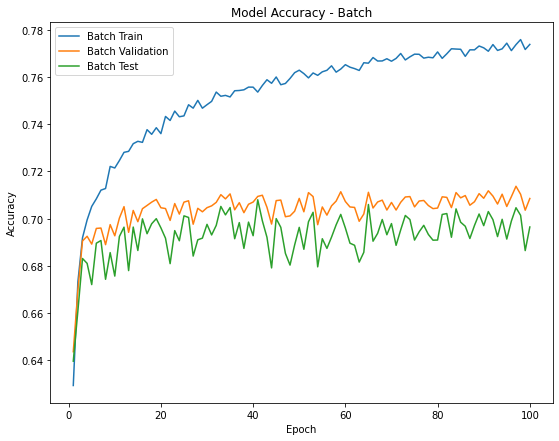

In [79]:
plt.figure(figsize=(9, 7))

plt.plot(x, batch_results[:, 0], label='Batch Train')
plt.plot(x, batch_results[:, 1], label='Batch Validation')
plt.plot(x, batch_results[:, 2], label='Batch Test')
plt.title('Model Accuracy - Batch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

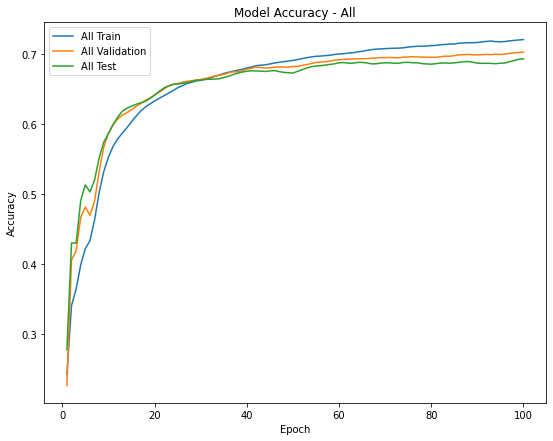

In [80]:
plt.figure(figsize=(9, 7))

plt.plot(x, all_results[:, 0], label='All Train')
plt.plot(x, all_results[:, 1], label="All Validation")
plt.plot(x, all_results[:, 2], label="All Test")
plt.title('Model Accuracy - All')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

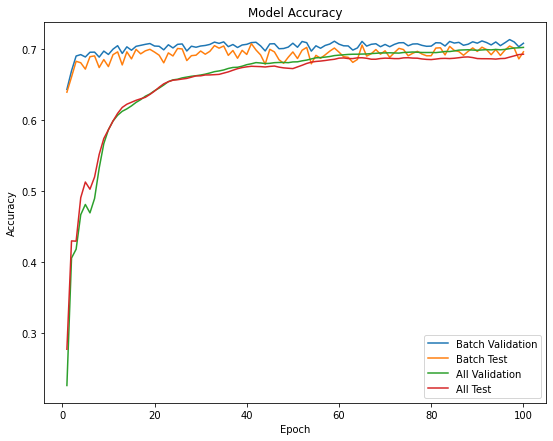

In [81]:
import numpy as np
from matplotlib import pyplot as plt

batch_results = np.array(batch_results)
all_results = np.array(all_results)

x = np.arange(1, 101)

plt.figure(figsize=(9, 7))

plt.plot(x, batch_results[:, 1], label="Batch Validation")
plt.plot(x, batch_results[:, 2], label="Batch Test")
plt.plot(x, all_results[:, 1], label="All Validation")
plt.plot(x, all_results[:, 2], label="All Test")
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# 2 Neighbor Sampling with Different Ratios

Now we will implement a simplified version of Neighbor Sampling by using DeepSNAP and NetworkX, and train models with different neighborhood sampling ratios.

To make the experiments faster, we will use the Cora graph here.

## Setup

In [82]:
import copy
import torch
import random
import numpy as np
import networkx as nx
import torch.nn as nn
import torch.nn.functional as F

In [84]:
from torch_geometric.nn import SAGEConv
from torch.utils.data import DataLoader
from torch_geometric.datasets import Planetoid
from torch.nn import Sequential, Linear, ReLU

from deepsnap.dataset import GraphDataset
from deepsnap.dataset import Graph

In [85]:
pyg_dataset = Planetoid('./tmp', 'Cora')

Processing...
Done!


In [87]:
print(pyg_dataset)

Cora()


## GNN Model

In [89]:
class GNN(torch.nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim, args):
    super(GNN, self).__init__()
    self.dropout = args['dropout']
    self.num_layers = args['num_layers']

    self.convs = nn.ModuleList()
    self.bns = nn.ModuleList()

    self.convs.append(SAGEConv(input_dim, hidden_dim))
    self.bns.append(nn.BatchNorm1d(hidden_dim))

    for I in range(self.num_layers - 2):
      self.convs.append(SAGEConv(hidden_dim, hidden_dim))
      self.bns.append(nn.BatchNorm1d(hidden_dim))
    
    self.convs.append(SAGEConv(hidden_dim, hidden_dim))
    self.post_mp = nn.Linear(hidden_dim, output_dim)

  def forward(self, data, mode='batch'):
    if mode == 'batch':
      edge_indices, x = data
      for i in range(len(self.convs) - 1):
        edge_index = edge_indices[i]
        x = self.convs[i](x, edge_index)
        x = self.bns[i](x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
      x = self.convs[-1](x, edge_indices[len(self.convs) - 1])
    
    else:
      x, edge_index = data.node_feature, data.edge_index
      
      for i in range(len(self.convs) - 1):
        x = self.convs[i](x, edge_index)
        x = self.bns[i](x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
      x = self.convs[-1](x, edge_index)
    x = self.post_mp(x)
    x = F.log_softmax(x, dim=1)
    
    return x

## Neighbor Sampling

Here we implement functions that will sample neighbors by using DeepSNAP and NetworkX.

Notice that node classification task on Cora is a semi-supervised classification task, here we keep all the labeled training nodes (140 nodes) by setting the last ratio to 1.

In [ ]:
def sample_neighbors(nodes, G, ratio, all_nodes):
    # This fuction takes a set of nodes, a NetworkX graph G and neighbor sampling ratio.
    # It will return sampled neighbors (unioned with input nodes) and edges between 
    neighbors = set()
    edges = []
    for node in nodes:
        neighbors_list = list(nx.neighbors(G, node))

        # We only sample the (ratio * number of neighbors) neighbors
        num = int(len(neighbors_list) * ratio)
        if num > 0:
            # Random shuffle the neighbors
            random.shuffle(neighbors_list)
            neighbors_list = neighbors_list[:num]
            for neighbor in neighbors_list:
                # Add neighbors
                neighbors.add(neighbor)
                edges.append((neighbor, node))
    return neighbors, neighbors.union(all_nodes), edges

def nodes_to_tensor(nodes):
    # This function transform a set of nodes to node index tensor
    node_label_index = torch.tensor(list(nodes), dtype=torch.long)
    return node_label_index

def edges_to_tensor(edges):
    # This function transform a set of edges to edge index tensor
    edge_index = torch.tensor(list(edges), dtype=torch.long)
    edge_index = torch.cat([edge_index, torch.flip(edge_index, [1])], dim=0)
    edge_index = edge_index.permute(1, 0)
    return edge_index

def relable(nodes, labeled_nodes, edges_list):
    # Relable the nodes, labeled_nodes and edges_list
    relabled_edges_list = []
    sorted_nodes = sorted(nodes)
    node_mapping = {node : i for i, node in enumerate(sorted_nodes)}
    for orig_edges in edges_list:
        relabeled_edges = []
        for edge in orig_edges:
            relabeled_edges.append((node_mapping[edge[0]], node_mapping[edge[1]]))
        relabled_edges_list.append(relabeled_edges)
    relabeled_labeled_nodes = [node_mapping[node] for node in labeled_nodes]
    relabeled_nodes = [node_mapping[node] for node in nodes]
    return relabled_edges_list, relabeled_nodes, relabeled_labeled_nodes

def neighbor_sampling(graph, K=2, ratios=(0.1, 0.1, 0.1)):
    # This function takes a DeepSNAP graph, K the number of GNN layers, and neighbor 
    # sampling ratios for each layer. This function returns relabeled node feature, 
    # edge indices and node_label_index

    assert K + 1 == len(ratios)

    labeled_nodes = graph.node_label_index.tolist()
    random.shuffle(labeled_nodes)
    num = int(len(labeled_nodes) * ratios[-1])
    if num > 0:
        labeled_nodes = labeled_nodes[:num]
    nodes_list = [set(labeled_nodes)]
    edges_list = []
    all_nodes = labeled_nodes
    for k in range(K):
        # Get nodes and edges from the previous layer
        nodes, all_nodes, edges = \
            sample_neighbors(nodes_list[-1], graph.G, ratios[len(ratios) - k - 2], all_nodes)
        nodes_list.append(nodes)
        edges_list.append(edges)
    
    # Reverse the lists
    nodes_list.reverse()
    edges_list.reverse()

    relabled_edges_list, relabeled_all_nodes, relabeled_labeled_nodes = \
        relable(all_nodes, labeled_nodes, edges_list)

    node_index = nodes_to_tensor(relabeled_all_nodes)
    # All node features that will be used
    node_feature = graph.node_feature[node_index]
    edge_indices = [edges_to_tensor(edges) for edges in relabled_edges_list]
    node_label_index = nodes_to_tensor(relabeled_labeled_nodes)
    log = "Sampled {} nodes, {} edges, {} labeled nodes"
    print(log.format(node_feature.shape[0], edge_indices[0].shape[1] // 2, node_label_index.shape[0]))
    return node_feature, edge_indices, node_label_index

## Training and Testing

In [ ]:
def train(train_graphs, val_graphs, args, model, optimizer, mode="batch"):
    best_val = 0
    best_model = None
    accs = []
    graph_train = train_graphs[0]
    graph_train.to(args['device'])
    for epoch in range(1, 1 + args['epochs']):
        model.train()
        optimizer.zero_grad()
        if mode == "batch":
            node_feature, edge_indices, node_label_index = neighbor_sampling(graph_train, args['num_layers'], args['ratios'])
            node_feature = node_feature.to(args['device'])
            node_label_index = node_label_index.to(args['device'])
            for i in range(len(edge_indices)):
                edge_indices[i] = edge_indices[i].to(args['device'])
            pred = model([edge_indices, node_feature])
            pred = pred[node_label_index]
            label = graph_train.node_label[node_label_index]
        elif mode == "community":
            graph = random.choice(train_graphs)
            graph = graph.to(args['device'])
            pred = model(graph, mode="all")
            pred = pred[graph.node_label_index]
            label = graph.node_label[graph.node_label_index]
        else:
            pred = model(graph_train, mode="all")
            label = graph_train.node_label
            pred = pred[graph_train.node_label_index]
        loss = F.nll_loss(pred, label)
        loss.backward()
        optimizer.step()

        train_acc, val_acc, test_acc = test(val_graphs, model)
        accs.append((train_acc, val_acc, test_acc))
        if val_acc > best_val:
            best_val = val_acc
            best_model = copy.deepcopy(model)
        print(f'Epoch: {epoch:02d}, '
              f'Loss: {loss:.4f}, '
              f'Train: {100 * train_acc:.2f}%, '
              f'Valid: {100 * val_acc:.2f}% '
              f'Test: {100 * test_acc:.2f}%')
    return best_model, accs

def test(graphs, model):
    model.eval()
    accs = []
    for graph in graphs:
        graph = graph.to(args['device'])
        pred = model(graph, mode="all")
        label = graph.node_label
        pred = pred[graph.node_label_index].max(1)[1]
        acc = pred.eq(label).sum().item()
        acc /= len(label)
        accs.append(acc)
    return accs

In [ ]:
args = {
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'dropout': 0.5,
    'num_layers': 2,
    'hidden_size': 64,
    'lr': 0.005,
    'epochs': 50,
    'ratios': (0.8, 0.8, 1),
}

## Full-Batch Training

In [ ]:
graphs_train, graphs_val, graphs_test = \
    GraphDataset.pyg_to_graphs(pyg_dataset, verbose=True, fixed_split=True)

graph_train = graphs_train[0]
graph_val = graphs_val[0]
graph_test = graphs_test[0]

model = GNN(graph_train.num_node_features, args['hidden_size'], graph_train.num_node_labels, args).to(args['device'])
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
graphs = [graph_train, graph_val, graph_test]
all_best_model, all_accs = train(graphs, graphs, args, model, optimizer, mode="all")
train_acc, val_acc, test_acc = test([graph_train, graph_val, graph_test], all_best_model)
print('Best model:',
      f'Train: {100 * train_acc:.2f}%, '
      f'Valid: {100 * val_acc:.2f}% '
      f'Test: {100 * test_acc:.2f}%')

## Sampling with Ratios 0.8

In [ ]:
args['ratios'] = (0.8, 0.8, 1)

graphs_train, graphs_val, graphs_test = \
    GraphDataset.pyg_to_graphs(pyg_dataset, verbose=True, fixed_split=True)

graph_train = graphs_train[0]
graph_val = graphs_val[0]
graph_test = graphs_test[0]

model = GNN(graph_train.num_node_features, args['hidden_size'], graph_train.num_node_labels, args).to(args['device'])
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
graphs = [graph_train, graph_val, graph_test]
batch_best_model, batch_accs = train(graphs, graphs, args, model, optimizer)
train_acc, val_acc, test_acc = test([graph_train, graph_val, graph_test], batch_best_model)
print('Best model:',
      f'Train: {100 * train_acc:.2f}%, '
      f'Valid: {100 * val_acc:.2f}% '
      f'Test: {100 * test_acc:.2f}%')

## Sampling with Ratios 0.3

In [ ]:
# Change the ratio to 0.3
args['ratios'] = (0.3, 0.3, 1)

graphs_train, graphs_val, graphs_test = \
    GraphDataset.pyg_to_graphs(pyg_dataset, verbose=True, fixed_split=True)

graph_train = graphs_train[0]
graph_val = graphs_val[0]
graph_test = graphs_test[0]

model = GNN(graph_train.num_node_features, args['hidden_size'], graph_train.num_node_labels, args).to(args['device'])
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
graphs = [graph_train, graph_val, graph_test]
batch_best_model, batch_accs_1 = train(graphs, graphs, args, model, optimizer)
train_acc, val_acc, test_acc = test([graph_train, graph_val, graph_test], batch_best_model)
print('Best model:',
      f'Train: {100 * train_acc:.2f}%, '
      f'Valid: {100 * val_acc:.2f}% '
      f'Test: {100 * test_acc:.2f}%')

## Visualization

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

batch_results = np.array(batch_accs)
batch_results_1 = np.array(batch_accs_1)
all_results = np.array(all_accs)

x = np.arange(1, 51)

plt.figure(figsize=(9, 7))

plt.plot(x, batch_results[:, 0], label="Batch 0.8 Train")
plt.plot(x, batch_results[:, 1], label="Batch 0.8 Validation")
plt.plot(x, batch_results[:, 2], label="Batch 0.8 Test")
plt.plot(x, batch_results_1[:, 0], label="Batch 0.3 Train")
plt.plot(x, batch_results_1[:, 1], label="Batch 0.3 Validation")
plt.plot(x, batch_results_1[:, 2], label="Batch 0.3 Test")
plt.plot(x, all_results[:, 0], label="All Train")
plt.plot(x, all_results[:, 1], label="All Validation")
plt.plot(x, all_results[:, 2], label="All Test")
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Here all accuracies are evaluated on the full-batch mode.

# 3 Cluster Sampling

Instead of the neighbor sampling, we can use another approach, subgraph (cluster) sampling, to scale up GNN. This approach is proposed in Cluster-GCN ([Chiang et al. (2019)](https://arxiv.org/abs/1905.07953)).

In this section, we will implement vanilla Cluster-GCN and experiment with 3 different community partition algorithms.

Notice that this section requires you have run the `Setup`, `GNN Model` and `Training and Testing` cells of the last section.

## Setup

In [ ]:
import copy
import torch
import random
import numpy as np
import networkx as nx
import torch.nn as nn
import torch.nn.functional as F
import community as community_louvain

from torch_geometric.nn import SAGEConv
from torch.utils.data import DataLoader
from torch_geometric.datasets import Planetoid
from torch.nn import Sequential, Linear, ReLU
from deepsnap.dataset import GraphDataset
from deepsnap.graph import Graph

pyg_dataset = Planetoid('./tmp', "Cora")

In [ ]:
args = {
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'dropout': 0.5,
    'num_layers': 2,
    'hidden_size': 64,
    'lr': 0.005,
    'epochs': 150,
}

## Partition the Graph into Clusters

Here we use following three community detection / partition algorithms to partition the graph into different clusters:
* [Kernighan–Lin algorithm (bisection)](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.kernighan_lin.kernighan_lin_bisection.html)
* [Clauset-Newman-Moore greedy modularity maximization](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.modularity_max.greedy_modularity_communities.html#networkx.algorithms.community.modularity_max.greedy_modularity_communities)
* [Louvain algorithm](https://python-louvain.readthedocs.io/en/latest/api.html)


To make the training more stable, we discard the cluster that has less than 10 nodes.

Let's first define these algorithms as DeepSNAP transformation on a graph.

In [ ]:
def preprocess(G, node_label_index, method="louvain"):
    graphs = []
    labeled_nodes = set(node_label_index.tolist())
    if method == "louvain":
        community_mapping = community_louvain.best_partition(G, resolution=10)
        communities = {}
        for node in community_mapping:
            comm = community_mapping[node]
            if comm in communities:
                communities[comm].add(node)
            else:
                communities[comm] = set([node])
        communities = communities.values()
    elif method == "bisection":
        communities = nx.algorithms.community.kernighan_lin_bisection(G)
    elif method == "greedy":
        communities = nx.algorithms.community.greedy_modularity_communities(G)

    for community in communities:
        nodes = set(community)
        subgraph = G.subgraph(nodes)
        # Make sure each subgraph has more than 10 nodes
        if subgraph.number_of_nodes() > 10:
            node_mapping = {node : i for i, node in enumerate(subgraph.nodes())}
            subgraph = nx.relabel_nodes(subgraph, node_mapping)
            # Get the id of the training set labeled node in the new graph
            train_label_index = []
            for node in labeled_nodes:
                if node in node_mapping:
                    # Append relabeled labeled node index
                    train_label_index.append(node_mapping[node])

            # Make sure the subgraph contains at least one training set labeled node
            if len(train_label_index) > 0:
                dg = Graph(subgraph)
                # Update node_label_index
                dg.node_label_index = torch.tensor(train_label_index, dtype=torch.long)
                graphs.append(dg)
    return graphs

## Louvain Preprocess

In [ ]:
graphs_train, graphs_val, graphs_test = \
    GraphDataset.pyg_to_graphs(pyg_dataset, verbose=True, fixed_split=True)

graph_train = graphs_train[0]
graph_val = graphs_val[0]
graph_test = graphs_test[0]
graphs = preprocess(graph_train.G, graph_train.node_label_index, method="louvain")
print("Partition the graph in to {} communities".format(len(graphs)))
avg_num_nodes = 0
avg_num_edges = 0
for graph in graphs:
    avg_num_nodes += graph.num_nodes
    avg_num_edges += graph.num_edges
avg_num_nodes = int(avg_num_nodes / len(graphs))
avg_num_edges = int(avg_num_edges / len(graphs))
print("Each community has {} nodes in average".format(avg_num_nodes))
print("Each community has {} edges in average".format(avg_num_edges))

## Louvain Training

In [ ]:
model = GNN(graph_train.num_node_features, args['hidden_size'], graph_train.num_node_labels, args).to(args['device'])
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
louvain_best_model, louvain_accs = train(graphs, [graph_train, graph_val, graph_test], args, model, optimizer, mode="community")
train_acc, val_acc, test_acc = test([graph_train, graph_val, graph_test], louvain_best_model)
print('Best model:',
      f'Train: {100 * train_acc:.2f}%, '
      f'Valid: {100 * val_acc:.2f}% '
      f'Test: {100 * test_acc:.2f}%')

## Bisection Preprocess

In [ ]:
graphs_train, graphs_val, graphs_test = \
    GraphDataset.pyg_to_graphs(pyg_dataset, verbose=True, fixed_split=True)

graph_train = graphs_train[0]
graph_val = graphs_val[0]
graph_test = graphs_test[0]
graphs = preprocess(graph_train.G, graph_train.node_label_index, method="bisection")
print("Partition the graph in to {} communities".format(len(graphs)))
avg_num_nodes = 0
avg_num_edges = 0
for graph in graphs:
    avg_num_nodes += graph.num_nodes
    avg_num_edges += graph.num_edges
avg_num_nodes = int(avg_num_nodes / len(graphs))
avg_num_edges = int(avg_num_edges / len(graphs))
print("Each community has {} nodes in average".format(avg_num_nodes))
print("Each community has {} edges in average".format(avg_num_edges))

## Bisection Training

In [ ]:
model = GNN(graph_train.num_node_features, args['hidden_size'], graph_train.num_node_labels, args).to(args['device'])
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
bisection_best_model, bisection_accs = train(graphs, [graph_train, graph_val, graph_test], args, model, optimizer, mode="community")
train_acc, val_acc, test_acc = test([graph_train, graph_val, graph_test], bisection_best_model)
print('Best model:',
      f'Train: {100 * train_acc:.2f}%, '
      f'Valid: {100 * val_acc:.2f}% '
      f'Test: {100 * test_acc:.2f}%')

## Greedy Preprocess

In [ ]:
graphs_train, graphs_val, graphs_test = \
    GraphDataset.pyg_to_graphs(pyg_dataset, verbose=True, fixed_split=True)

graph_train = graphs_train[0]
graph_val = graphs_val[0]
graph_test = graphs_test[0]
graphs = preprocess(graph_train.G, graph_train.node_label_index, method="greedy")
print("Partition the graph in to {} communities".format(len(graphs)))
avg_num_nodes = 0
avg_num_edges = 0
for graph in graphs:
    avg_num_nodes += graph.num_nodes
    avg_num_edges += graph.num_edges
avg_num_nodes = int(avg_num_nodes / len(graphs))
avg_num_edges = int(avg_num_edges / len(graphs))
print("Each community has {} nodes in average".format(avg_num_nodes))
print("Each community has {} edges in average".format(avg_num_edges))

## Greedy Training

In [ ]:
model = GNN(graph_train.num_node_features, args['hidden_size'], graph_train.num_node_labels, args).to(args['device'])
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
greedy_best_model, greedy_accs = train(graphs, [graph_train, graph_val, graph_test], args, model, optimizer, mode="community")
train_acc, val_acc, test_acc = test([graph_train, graph_val, graph_test], greedy_best_model)
print('Best model:',
      f'Train: {100 * train_acc:.2f}%, '
      f'Valid: {100 * val_acc:.2f}% '
      f'Test: {100 * test_acc:.2f}%')

## Full-Batch Training

In [ ]:
graphs_train, graphs_val, graphs_test = \
    GraphDataset.pyg_to_graphs(pyg_dataset, verbose=True, fixed_split=True)

graph_train = graphs_train[0]
graph_val = graphs_val[0]
graph_test = graphs_test[0]

model = GNN(graph_train.num_node_features, args['hidden_size'], graph_train.num_node_labels, args).to(args['device'])
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
graphs = [graph_train, graph_val, graph_test]
all_best_model, all_accs = train(graphs, graphs, args, model, optimizer, mode="all")
train_acc, val_acc, test_acc = test([graph_train, graph_val, graph_test], all_best_model)
print('Best model:',
      f'Train: {100 * train_acc:.2f}%, '
      f'Valid: {100 * val_acc:.2f}% '
      f'Test: {100 * test_acc:.2f}%')

## Visualization

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

louvain_results = np.array(louvain_accs)
bisection_results = np.array(bisection_accs)
greedy_results = np.array(greedy_accs)
all_results = np.array(all_accs)

x = np.arange(1, 151)

plt.figure(figsize=(9, 7))

plt.plot(x, louvain_results[:, 1], label="Louvain Validation")
plt.plot(x, louvain_results[:, 2], label="Louvain Test")
plt.plot(x, bisection_results[:, 1], label="Bisection Validation")
plt.plot(x, bisection_results[:, 2], label="Bisection Test")
plt.plot(x, greedy_results[:, 1], label="Greedy Validation")
plt.plot(x, greedy_results[:, 2], label="Greedy Test")
plt.plot(x, all_results[:, 1], label="All Validation")
plt.plot(x, all_results[:, 2], label="All Test")
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()